### Read in csv file
- label being `Bankrupt?`
- 95 features that need to be selected for prediction
- confirm no NaN values in DataFrame

In [55]:
%load_ext autoreload
%autoreload 2
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_theme()
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
data_path = '../data/data.csv'
data_all = pd.read_csv(data_path)
target = 'Bankrupt?'
scaler = StandardScaler()
data_X = data_all.drop(columns=target)
data_Y = data_all[target]
# data_all.isnull().sum().sum()

### Visualization
- observe data imbalance (positive : negative = 220 : 6599), with total data number being 6819
- correlation between each feature

Text(-0.30555555555555536, 0.5, 'count')

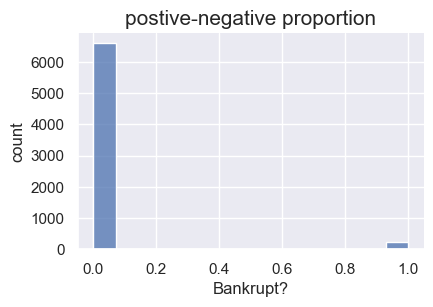

In [43]:
# sns.set_theme(rc={"figure.figsize":(10, 5)})
sns.displot(data_all[target], height=3, aspect=1.5)
plt.title(label='postive-negative proportion', size=15)
plt.xlabel(xlabel=target, size=12)
plt.ylabel(ylabel='count', size=12)

<Axes: >

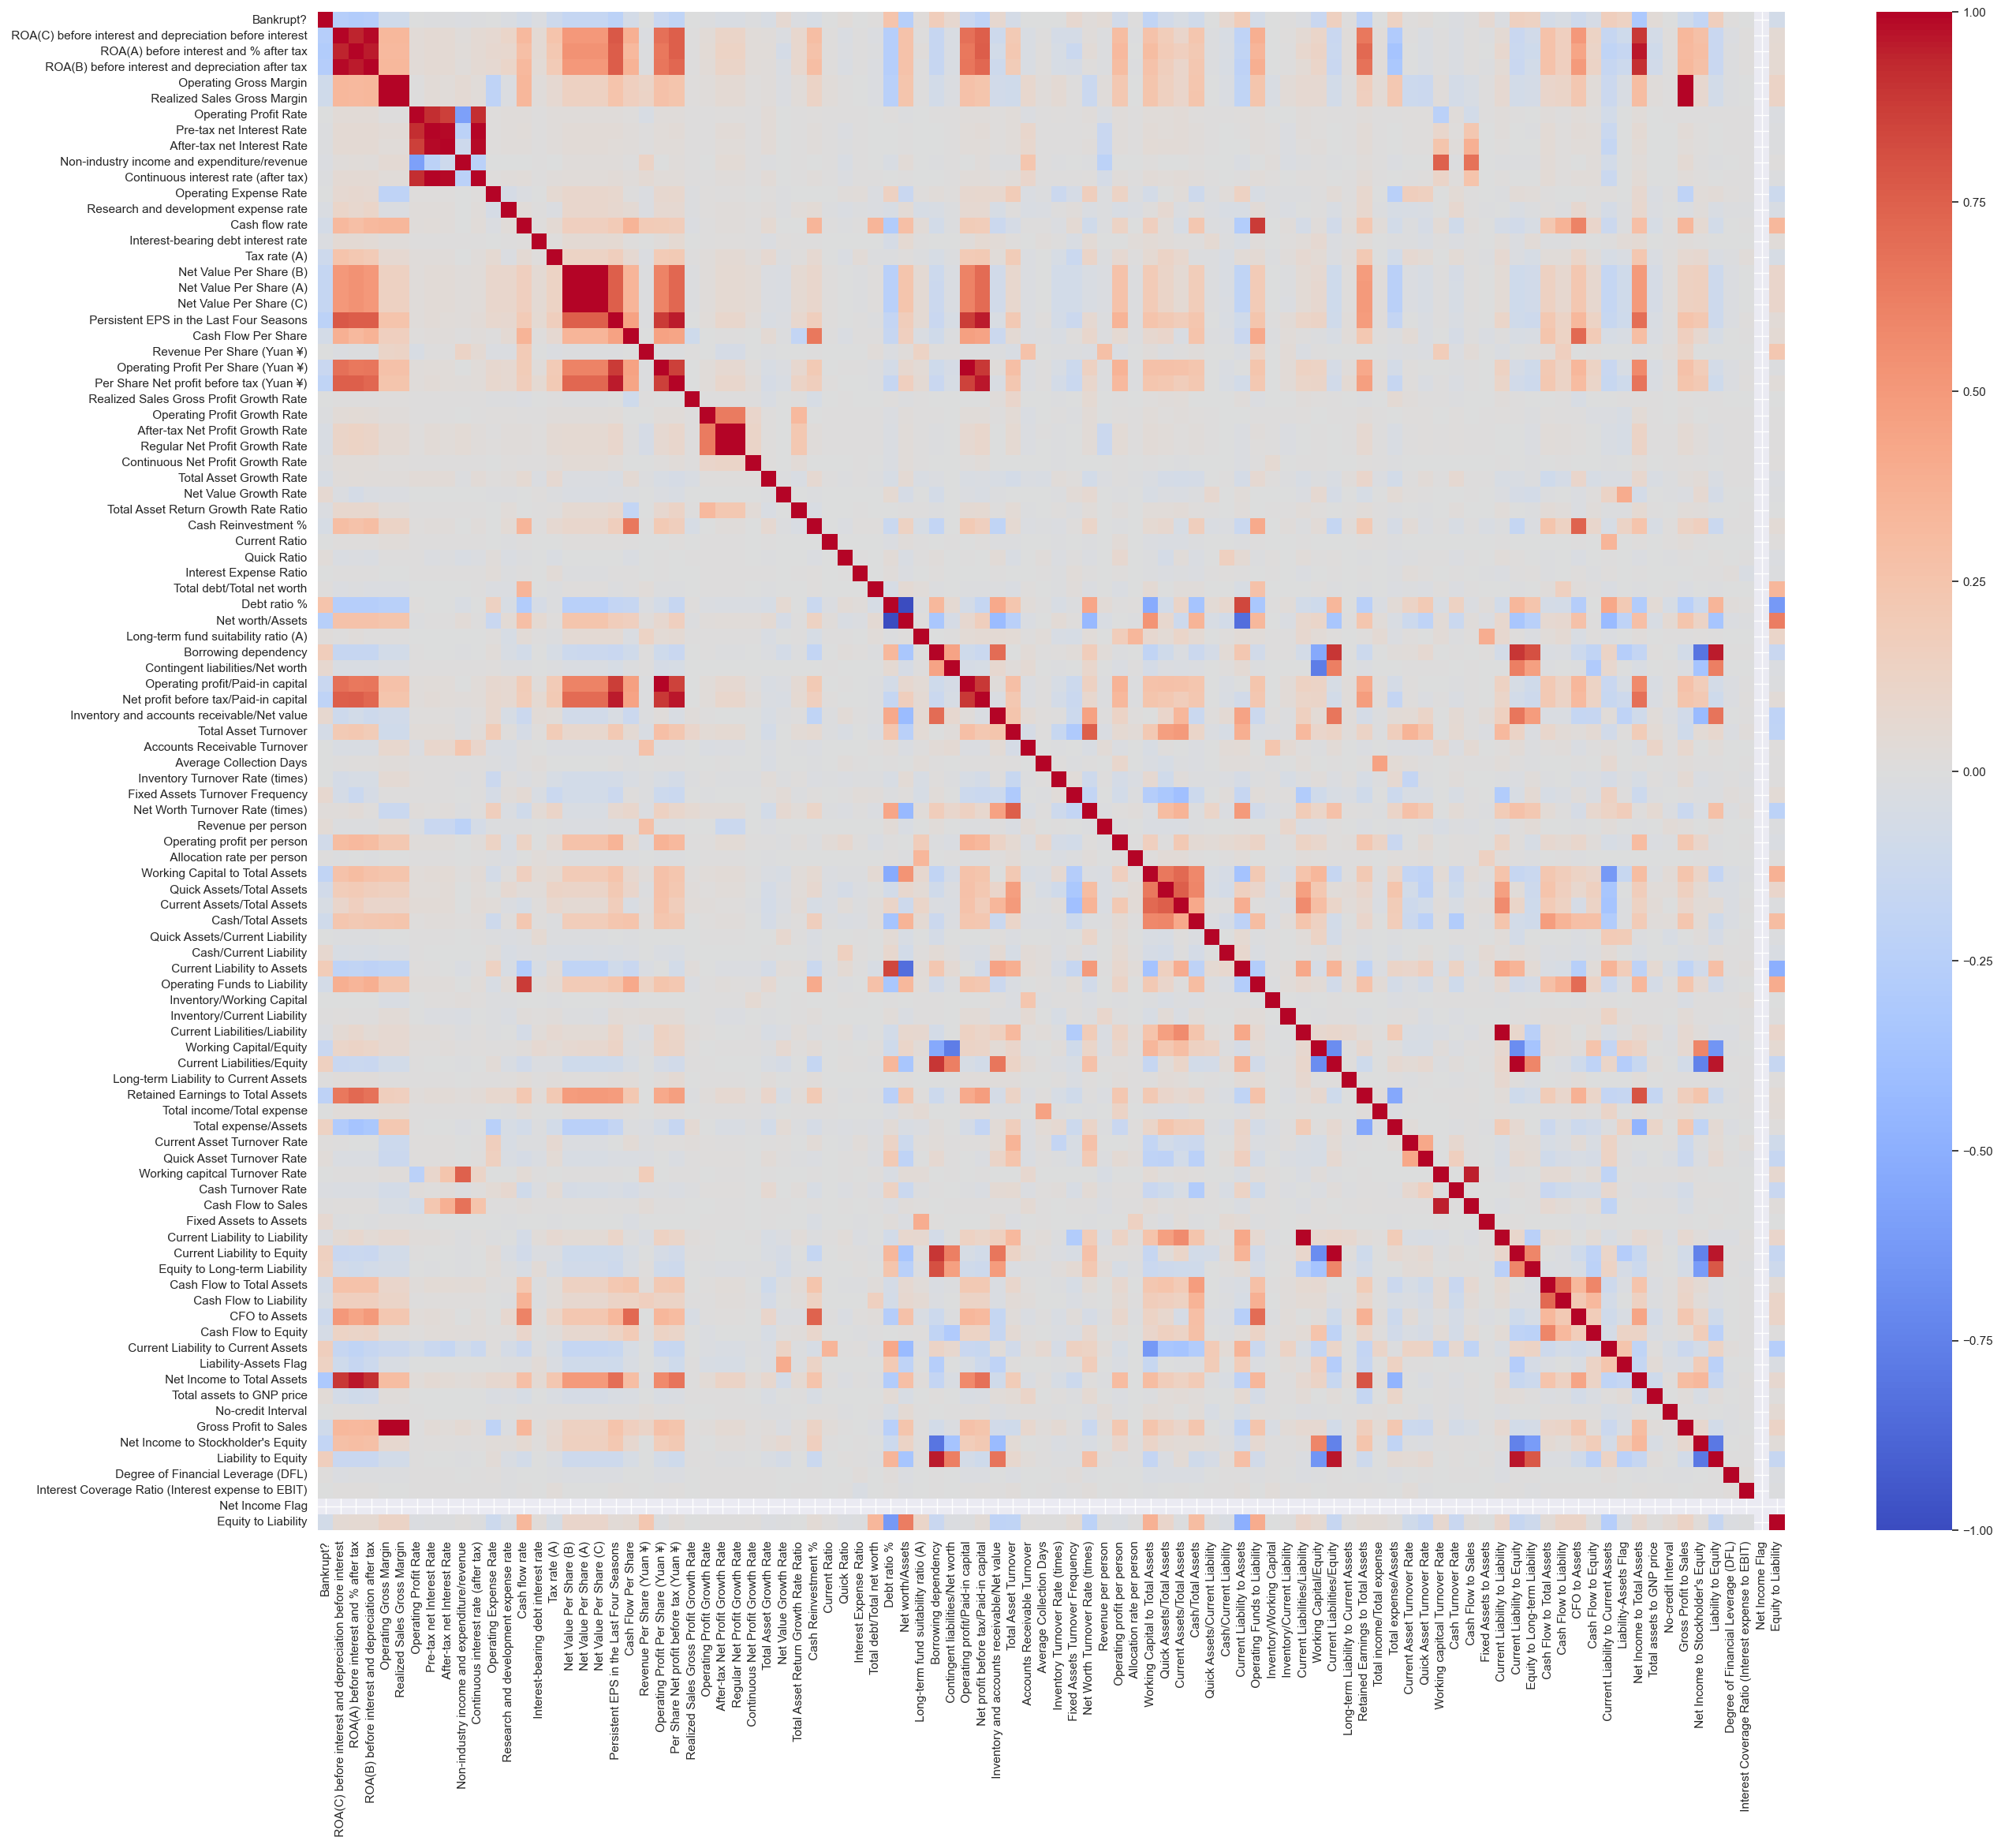

In [46]:
corr_matrix = data_all.corr()
plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, cmap='coolwarm')

#### Remove highly correlated features

In [150]:
corr_mat = data_X.corr().abs()
# Create a mask to ignore the upper triangle (duplicates) and the diagonal
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
data_X = data_X.drop(columns=to_drop)
copy_X = data_X.copy()
data_X = scaler.fit_transform(data_X)
data_Y = data_Y.values

### Selection of features
- `mutual_info`: capturing non-linear relationship
- `f_classif`: using F distribution
- `chi2`: using $\chi^2$ distribution

In [100]:
%load_ext autoreload
%autoreload 2
from utils.UniVarSelector import UniVarSelector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: title={'center': 'Feature importances (with score threshold = 0.1)'}>

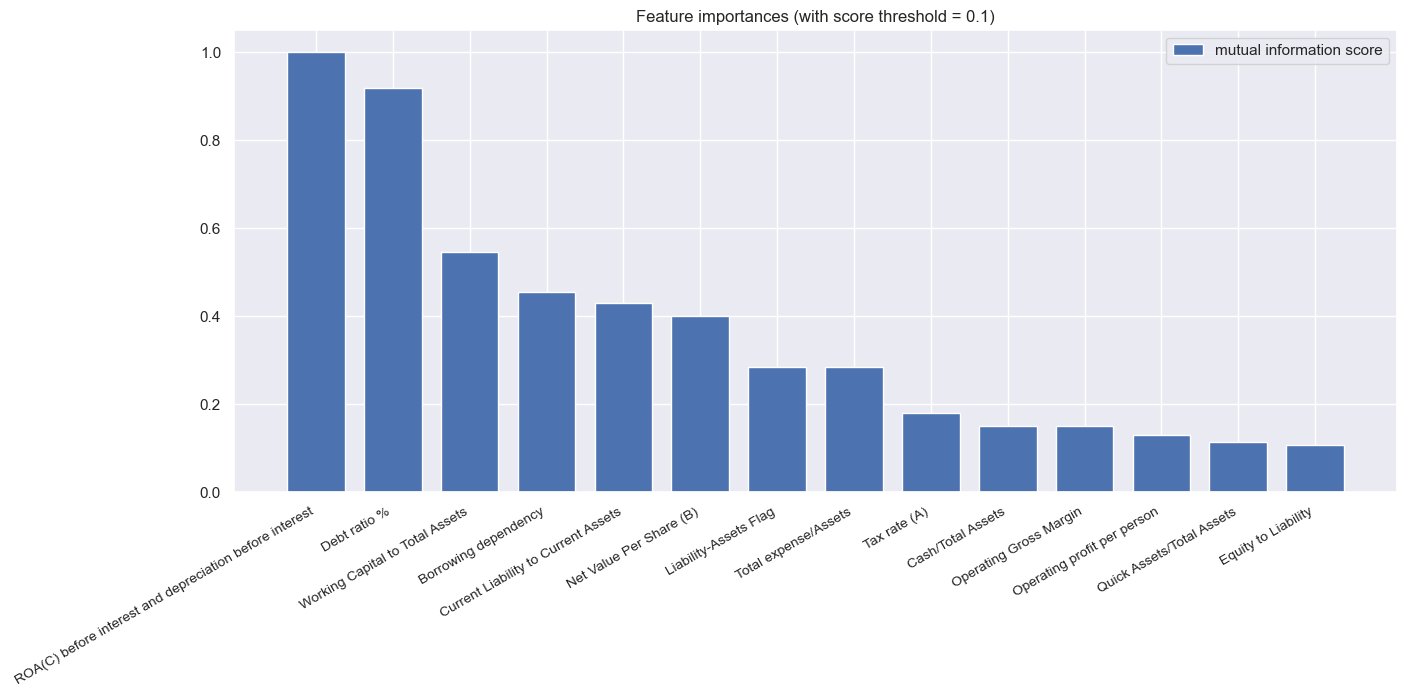

In [172]:
selector = UniVarSelector(data_X, data_Y, percent=30, method='f_classif')
features_f = selector.fit()
selector.plot(columns=copy_X.columns.values, threshold=0.1)

In [127]:
selector = UniVarSelector(data_X, data_Y, percent=30, method='mutual_info_classif')
features_mutual_info, index = selector.fit()

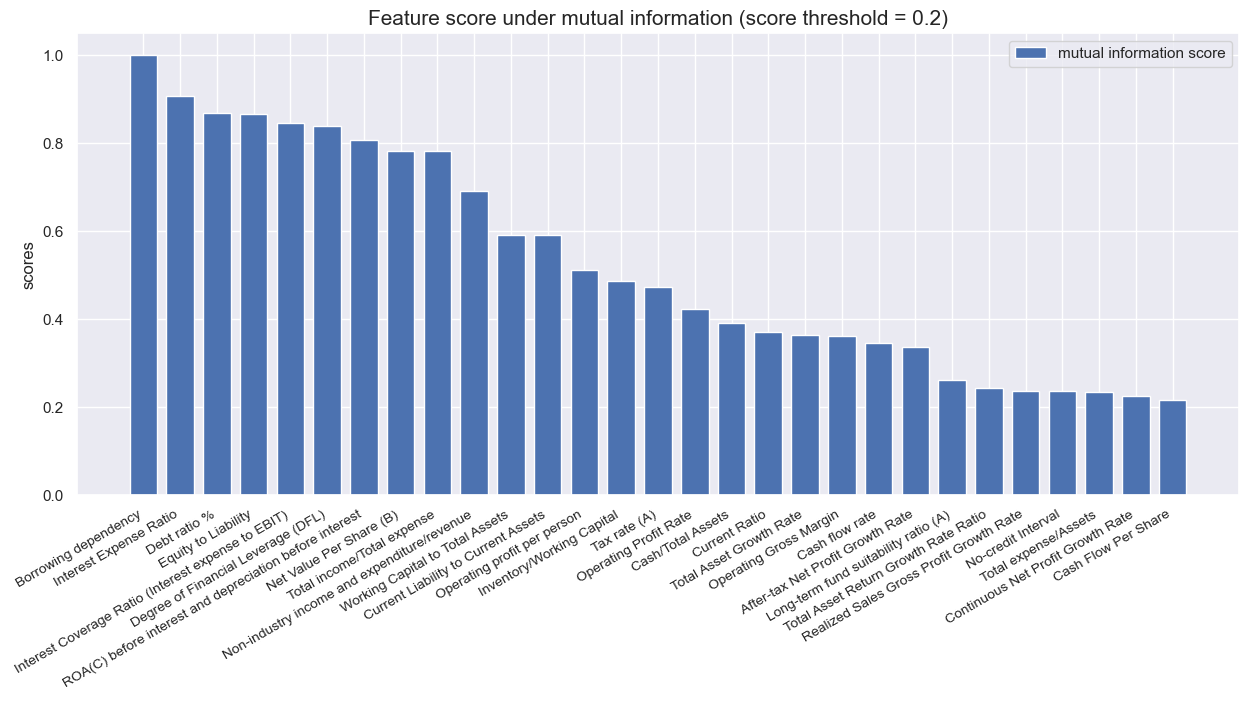

In [167]:
ax = selector.plot(figsize=(15,6), columns=copy_X.columns.values, threshold=.2)
ax.set_title('Feature score under mutual information (score threshold = 0.2)', size=15)
ax.set_ylabel('scores')
# plt.savefig('../thesis/images/score_mutual_info.png', dpi=200)

In [93]:
copy_f = np.sort(features_f)
copy_mi = np.sort(features_mutual_info)
print(f'Features chosen by f_classif: {copy_f} \n \
    features chosen by mutual_info: {copy_mi}')

Features chosen by f_classif: [ 0  1  6  8  9 10 24 26 32 34 36 37 38 40 46 53 54 60] 
     features chosen by mutual_info: [ 0  2  3  6  8  9 22 24 26 34 36 38 41 45 53 57 58 60]


#### When using `f_classif`, observed numerical unstability, check the feature selected indeed satisfy normal distribution
- Q-Q plot for separate features chosen by `f_classif`
- check for $x|y=1\sim \mathcal{N}(\mu_0, \Sigma)$, $x|y=0\sim \mathcal{N}(\mu_1, \Sigma)$

In [47]:
import scipy.stats as stats
def extract_features(data, feature_index: np.ndarray):
    """Split data[feature_index] into positive and negative samples"""
    mask = (data[:, 0] == 1)
    features = data[:, feature_index + 1] # data still contains label
    return features[mask], features[np.logical_not(mask)] # 1, 0

In [156]:
label_ = data_all[target].values
train_ = data_all.drop(columns=target).values
data_array = data_all.values

In [157]:
pos, neg = extract_features(data_array, features_mutual_info)
scaler = StandardScaler()
neg, pos = scaler.fit_transform(neg), scaler.fit_transform(pos)

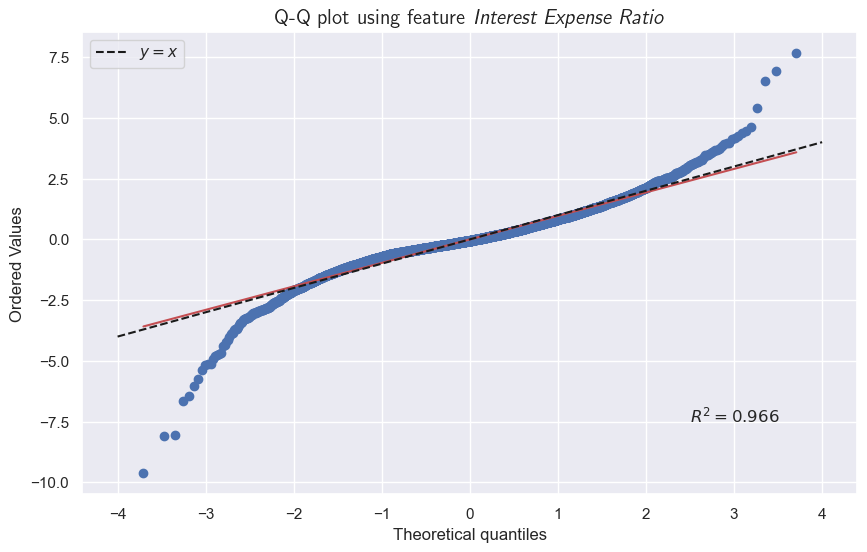

In [164]:
# Q - Q plot to test for normality
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.text(2.5, -7.5, r"$R^2=0.966$")
_, fit_params = stats.probplot(neg[:, 1], dist='norm', plot=plt)
ax.set_title(r"Q-Q plot using feature \textit{Interest Expense Ratio}", usetex=True, size=15)
plt.plot(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50), 
        color='k', linestyle='--', label=r'$y=x$') # y=x
plt.legend()
plt.savefig('../thesis/images/qqplot_interest_expense_ratio.png', dpi=200)

In [163]:
fit_params

(0.9668321655563094, 1.3989045647818186e-14, 0.9663292642864297)

#### creating own Q-Q plot without using `scipy.stats`

Text(0.5, 1.0, 'Q-Q plot')

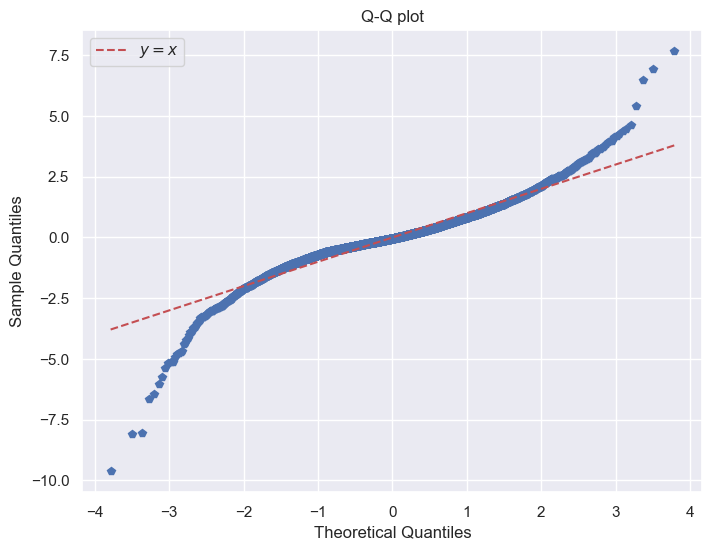

In [210]:
data_plot = np.sort(neg[:, 1])
mean, std = np.mean(data_plot), np.std(data_plot)
prob = (np.arange(1, len(data_plot) + 1) - .5) / len(data_plot)
y_i = stats.norm.ppf(prob, loc=mean, scale=std)
plt.figure(figsize=(8,6))
plt.plot(y_i, data_plot, 'p')
plt.plot([min(y_i), max(y_i)], [min(y_i), max(y_i)], 'r--', label=r'$y=x$')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
plt.title('Q-Q plot')

### Multivariate Gaussian checking (can also be done via checking of separate variables)

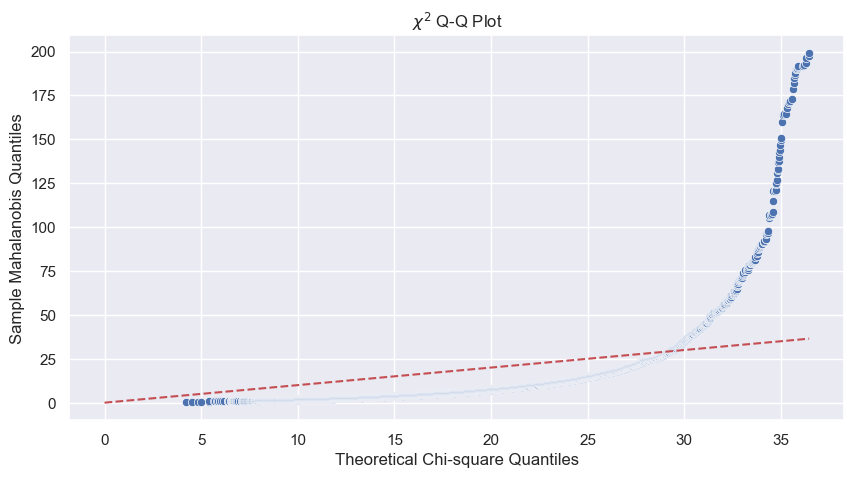

In [231]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis

scaler = StandardScaler()
neg = scaler.fit_transform(neg)

# Mahalanobis distances
cov_matrix = np.cov(neg, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_distr = np.mean(neg, axis=0)

d2 = np.array([mahalanobis(x, mean_distr, inv_cov_matrix) for x in neg])

# Chi-square Q-Q plot
df_qq = pd.DataFrame()
df_qq['Mahalanobis'] = np.sort(d2**2)
df_qq['Chi2'] = np.sort(np.random.chisquare(df=neg.shape[1], size=neg.shape[0]))

df_qq = df_qq[df_qq['Mahalanobis'] < 200]

sns.scatterplot(x='Chi2', y='Mahalanobis', data=df_qq)
plt.plot([0, max(df_qq['Chi2'])], [0, max(df_qq['Chi2'])], color='r', linestyle='--')
plt.xlabel('Theoretical Chi-square Quantiles')
plt.ylabel('Sample Mahalanobis Quantiles')
plt.title(r'$\chi^2$ Q-Q Plot')
plt.show()